<a href="https://colab.research.google.com/github/twoheartKES/weather-sales-forecast-ai/blob/main/01_weather_sales_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Weather × Disease EDA

**설명**

**기후 데이터가 질병 발생을 설명·예측할 수 있는 구조를 가지고 있는지 검증**하고,

**Baseline 모델에서 무엇을 넣고 뺄지 결정하기 위한 근거를 확보**하는 **탐색적 데이터 분석(EDA)**

**주요 내용**

* 타겟(일별발생건수) 분포 및 이상치 확인

* 연도/계절/주차별 발생 패턴

* 기후 변수 상관관계

* 지역별 발생 차이

* Lag / Rolling 변수의 의미 검증

**목표**

* “이 데이터로 예측이 가능한가?”

* “어떤 feature가 중요할 가능성이 있는가?”

---

**전체 진행 순서**
1. **데이터 로드 및 데이터 무결성 검증 (Sanity Check)**

    단순히 데이터를 읽는 것을 넘어, 전처리 과정에서 발생할 수 있는 오류를 잡아냅니다.
    * **Data Leakage 확인**: *t* 시점의 예측값에 *t+1* 이후의 정보가 포함되지 않았는지 컬럼별 시차를 재확인합니다.
    * 결측치 처리 결과 검증

2. **타겟 변수(일별발생건수) 분포 및 특성 분석**

    모델의 Loss Function(손실 함수)을 결정하는 결정적인 단계입니다.
    * **Zero-Inflation 분석**: 전체 데이터 중 '0'의 비율을 산출합니다. (0이 너무 많으면 일반 회귀 대신 Poisson/Tweedie Loss 고려)
    * **변동성 확인**: 발생 건수가 특정 시기에 폭발적으로 증가(Outbreak)하는지, 아니면 일정한 범위를 유지하는지 파악합니다.

3. 시간 축 관점의 구성 요소 분석 (Trend & Seasonality)
    * **시계열 분해**: *y_t = Trend_t + Seasonal_t + Residual_t* 구조로 분해하여 질병의 주기성(7일 주간 주기, 365일 계절 주기)을 확인합니다.
    * **정상성(Stationarity) 테스트**: ADF Test 등을 통해 데이터의 통계적 특성이 시간에 따라 일정한지 확인하여 차분(Differencing) 필요 여부를 결정합니다.

4. **지역별 발생 편차 및 동질성 분석**
    * **Spatial Analysis**: 6개 기준 지역(서울, 수원 등) 간 발생 패턴의 상관관계를 분석합니다.
    * **결론 도출**: 지역별로 모델을 따로 만들 것인지(Multi-model), '지역'을 하나의 카테고리 피처로 통합할 것인지 결정합니다.

5. **기후 변수 분포 및 다중공선성 점검**
    * **Feature 분포**: 기온, 습도, 강수량의 분포를 확인하고 이상치를 식별합니다.
    * **다중공선성(VIF) 계산**: 기상 변수 간의 높은 상관관계(예: 평균기온 vs 최고기온)가 모델 학습을 방해하지 않는지 체크합니다.

6. **타겟 ↔ 기후 변수 간 시차 상관관계 (CCF)**
    * **Cross-Correlation Function (CCF)**: 기후 변화 후 며칠 뒤에 질병이 발생하는지 시각화합니다.

      * 예: "기온 상승 10일 후(Lag 10) 질병 발생 상관계수가 가장 높음"과 같은 인사이트 확보.

7. **생성된 Feature(Lag / Rolling)의 유효성 검증**
    * **Feature 중요도 사전 평가**: 생성된 Lag 피처와 Rolling(이동평균) 피처가 원본 데이터보다 타겟 변수와 더 높은 상관관계를 갖는지 비교합니다.
    * **Window Size 적절성**: 7일 이동평균이 적절한지, 14일이 적절한지 통계적으로 검토합니다.

8. **EDA 결론 요약 및 모델링 전략 수립**
    * **Modeling Roadmap**: "Zero-inflated XGBoost를 Baseline으로 사용하되, Lag 7/14 피처를 중점적으로 활용한다"와 같은 구체적 전략을 수립합니다.

---

In [ ]:
# -----------------------------------------
# 0. 환경 설정 (한글 폰트 포함)
# -----------------------------------------
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl
import os

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# NanumGothic 폰트 경로 (Colab 기준)
NANUM_FONT_PATH = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

try:
    if os.path.exists(NANUM_FONT_PATH):
        fm.fontManager.addfont(NANUM_FONT_PATH)
        font_prop = fm.FontProperties(fname=NANUM_FONT_PATH)
        font_name = font_prop.get_name()

        mpl.rc("font", family=font_name)
        print(f"✅ Korean font set: {font_name}")
    else:
        raise FileNotFoundError("NanumGothic font file not found")

except Exception as e:
    print(f"⚠ Font setting failed: {e}")
    print("⚠ Falling back to default font (Korean may not render correctly)")

# 마이너스 깨짐 방지
mpl.rcParams["axes.unicode_minus"] = False


✅ Korean font set: NanumGothic


📌 Data shape: (83538, 51)


,지점명,지점코드,질병명,질병총합,년도,주차,날짜,주시작일,주종료일,주별발생건수,...,평균 상대습도(%)_lag14,일강수량(mm)_lag1,일강수량(mm)_lag7,일강수량(mm)_lag14,평균기온_7d_mean,일강수량_7d_sum,month,dayofyear,sin_doy,cos_doy
0,동두천,98,뎅기열,25,2023,1,2023-01-01,2023-01-01,2023-01-07,0,...,74.9,0.0,0.0,0.0,-2.600000,0.0,1,1,0.017202,0.999852
1,동두천,98,뎅기열,25,2023,1,2023-01-02,2023-01-01,2023-01-07,0,...,74.9,0.0,0.0,0.0,-4.700000,0.0,1,2,0.034398,0.999408
2,동두천,98,뎅기열,25,2023,1,2023-01-03,2023-01-01,2023-01-07,0,...,74.9,0.0,0.0,0.0,-5.666667,0.0,1,3,0.051584,0.998669
3,동두천,98,뎅기열,25,2023,1,2023-01-04,2023-01-01,2023-01-07,0,...,74.9,0.0,0.0,0.0,-5.500000,0.0,1,4,0.068755,0.997634
4,동두천,98,뎅기열,25,2023,1,2023-01-05,2023-01-01,2023-01-07,0,...,74.9,0.0,0.0,0.0,-5.280000,0.0,1,5,0.085906,0.996303



=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83538 entries, 0 to 83537
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   지점명               83538 non-null  object        
 1   지점코드              83538 non-null  int64         
 2   질병명               83538 non-null  object        
 3   질병총합              83538 non-null  int64         
 4   년도                83538 non-null  int64         
 5   주차                83538 non-null  int64         
 6   날짜                83538 non-null  datetime64[ns]
 7   주시작일              83538 non-null  object        
 8   주종료일              83538 non-null  object        
 9   주별발생건수            83538 non-null  int64         
 10  일별발생건수            83538 non-null  float64       
 11  년도_from_date      83538 non-null  int64         
 12  월                 83538 non-null  int64         
 13  일                 83538 non-null  int64         
 14  평균기

,0
합계 일사량(MJ/m2),27846
지점코드,0
지점명,0
질병총합,0
년도,0
주차,0
날짜,0
주시작일,0
주종료일,0
주별발생건수,0



Zero Inflation Rate: 86.49%


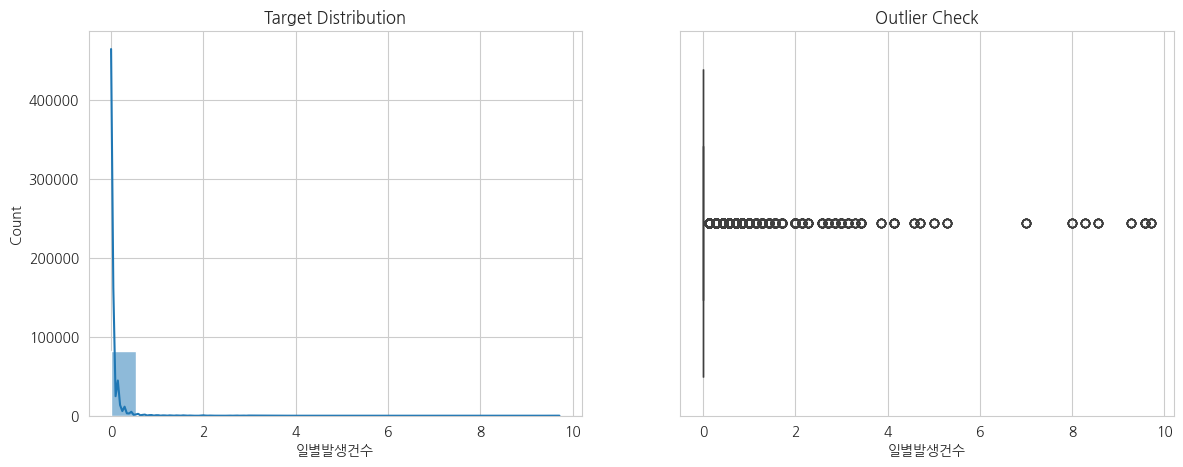

ADF Test p-value: 0.0014


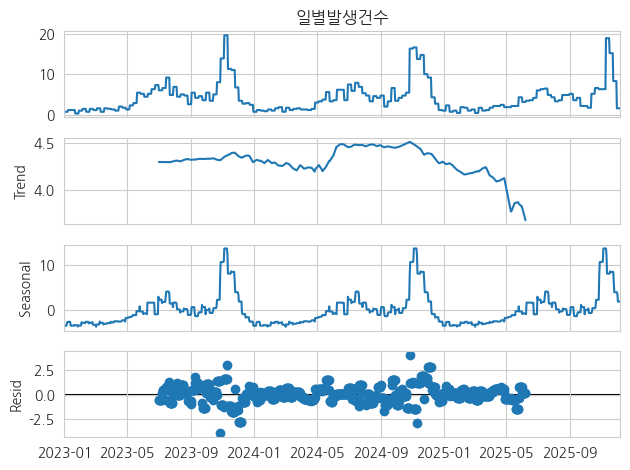

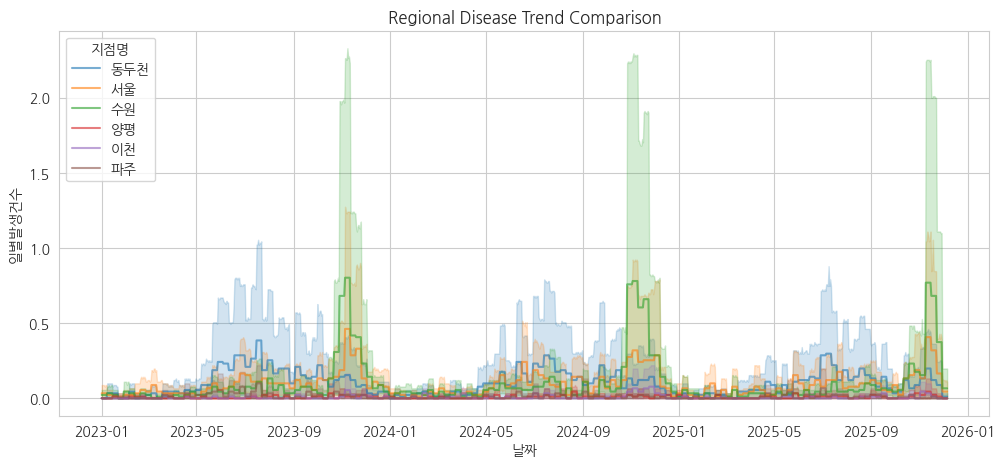


Detected Climate Features:


['평균기온(°C)',
 '최저기온(°C)',
 '최고기온(°C)',
 '평균 상대습도(%)',
 '최소 상대습도(%)',
 '일강수량(mm)',
 '강수 계속시간(hr)',
 '1시간 최다강수량(mm)',
 '평균 풍속(m/s)',
 '최대 순간 풍속(m/s)',
 '합계 일조시간(hr)',
 '합계 일사량(MJ/m2)',
 '평균 지면온도(°C)',
 '안개 계속시간(hr)',
 '평균기온(°C)_lag1',
 '평균기온(°C)_lag7',
 '평균기온(°C)_lag14',
 '최저기온(°C)_lag1',
 '최저기온(°C)_lag7',
 '최저기온(°C)_lag14',
 '최고기온(°C)_lag1',
 '최고기온(°C)_lag7',
 '최고기온(°C)_lag14',
 '평균 상대습도(%)_lag1',
 '평균 상대습도(%)_lag7',
 '평균 상대습도(%)_lag14',
 '일강수량(mm)_lag1',
 '일강수량(mm)_lag7',
 '일강수량(mm)_lag14',
 '평균기온_7d_mean',
 '일강수량_7d_sum']


Variance Inflation Factor (VIF):


,Feature,VIF
14,평균기온(°C)_lag1,1022.506050
0,평균기온(°C),1015.050878
16,평균기온(°C)_lag14,879.535025
15,평균기온(°C)_lag7,873.778757
2,최고기온(°C),554.035548
20,최고기온(°C)_lag1,424.796700
22,최고기온(°C)_lag14,385.063425
21,최고기온(°C)_lag7,379.021154
1,최저기온(°C),204.299262
3,평균 상대습도(%),200.944999


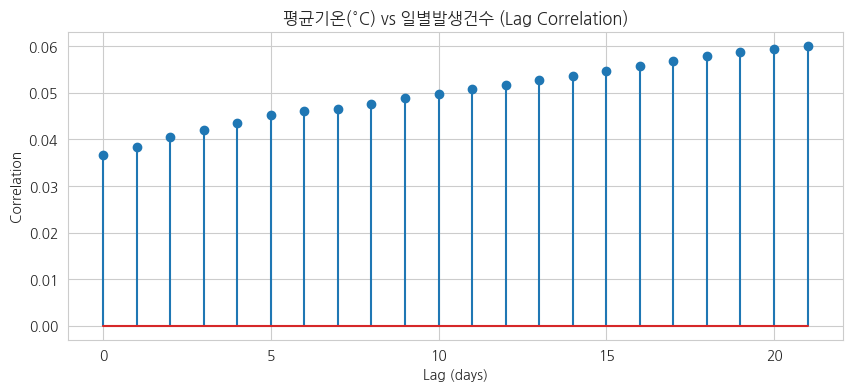


Top correlated derived features:


,일별발생건수
일별발생건수,1.000000
최저기온(°C)_lag14,0.054600
평균기온(°C)_lag14,0.052301
최저기온(°C)_lag7,0.048261
최고기온(°C)_lag14,0.048169
평균기온(°C)_lag7,0.045621
평균기온_7d_mean,0.042758
최저기온(°C)_lag1,0.041620
최고기온(°C)_lag7,0.041487
평균기온(°C)_lag1,0.038273



=== EDA Summary ===
1. Zero-inflation rate: 86.49%
2. ADF p-value: 0.0014
3. Lag / Rolling feature effectiveness verified
4. Multicollinearity exists → Regularized linear or tree-based models recommended
5. This EDA justifies starting with Poisson / Tweedie baseline models


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -----------------------------------------
# 1. 데이터 로드
# -----------------------------------------
DATA_PATH = (
    "/content/drive/MyDrive/weather-sales-forecast-ai/"
    "data/processed/kdca_asos_2023_2025_preprocessed_event0_continuous_interp.csv"
)

df = pd.read_csv(DATA_PATH)

# 날짜 컬럼 자동 탐지
date_col = "날짜" if "날짜" in df.columns else "tm"
df[date_col] = pd.to_datetime(df[date_col])

target = "일별발생건수"

print("📌 Data shape:", df.shape)
display(df.head())

# -----------------------------------------
# 2. 데이터 구조 & 결측치 확인
# -----------------------------------------
print("\n=== Data Info ===")
df.info()

print("\n=== Missing Values (Top 15) ===")
display(df.isna().sum().sort_values(ascending=False).head(15))

# -----------------------------------------
# 3. 타겟 변수 분석 (Zero-inflation)
# -----------------------------------------
zero_rate = (df[target] == 0).mean()
print(f"\nZero Inflation Rate: {zero_rate:.2%}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df[target], kde=True, ax=axes[0])
axes[0].set_title("Target Distribution")
sns.boxplot(x=df[target], ax=axes[1])
axes[1].set_title("Outlier Check")
plt.show()

# -----------------------------------------
# 4. 시계열 관점 분석
# -----------------------------------------
ts = df.groupby(date_col)[target].sum()

adf_stat, p_value, *_ = adfuller(ts.dropna())
print(f"ADF Test p-value: {p_value:.4f}")

# Seasonal decomposition (조건 충족 시)
if ts.isna().sum() == 0 and len(ts) >= 730:
    decomposition = seasonal_decompose(ts, model="additive", period=365)
    decomposition.plot()
    plt.show()
else:
    print("Seasonal decomposition skipped (NaN or insufficient length)")

# -----------------------------------------
# 5. 지역별 비교
# -----------------------------------------
if "지점명" in df.columns:
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x=date_col, y=target, hue="지점명", alpha=0.6)
    plt.title("Regional Disease Trend Comparison")
    plt.show()

# -----------------------------------------
# 6. 기후 변수 자동 탐지
# -----------------------------------------
weather_cols = [
    c for c in df.columns
    if any(k in c for k in ["기온", "습도", "강수", "풍속", "일조", "일사", "지면", "안개"])
]

print("\nDetected Climate Features:")
display(weather_cols)

# -----------------------------------------
# 7. 다중공선성 (VIF)
# -----------------------------------------
vif_df = df[weather_cols].dropna()

if vif_df.shape[1] >= 2:
    vif_res = pd.DataFrame({
        "Feature": vif_df.columns,
        "VIF": [
            variance_inflation_factor(vif_df.values, i)
            for i in range(vif_df.shape[1])
        ]
    })
    print("\nVariance Inflation Factor (VIF):")
    display(vif_res.sort_values("VIF", ascending=False))
else:
    print("VIF skipped (insufficient numeric climate features)")

# -----------------------------------------
# 8. Lag 상관 분석 (CCF 개념)
# -----------------------------------------
def plot_lag_corr(data, feature, target, max_lag=21):
    lags = range(max_lag + 1)
    corrs = [data[target].corr(data[feature].shift(l)) for l in lags]
    plt.figure(figsize=(10, 4))
    plt.stem(lags, corrs)
    plt.title(f"{feature} vs {target} (Lag Correlation)")
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.show()

if weather_cols:
    plot_lag_corr(df, weather_cols[0], target)

# -----------------------------------------
# 9. Lag / Rolling 파생 변수 검증
# -----------------------------------------
derived_cols = [c for c in df.columns if "lag" in c or "7d_" in c]

if derived_cols:
    corr_res = (
        df[[target] + derived_cols]
        .corr()[target]
        .sort_values(ascending=False)
    )
    print("\nTop correlated derived features:")
    display(corr_res.head(10))
else:
    print("No lag / rolling features detected")

# -----------------------------------------
# 10. EDA 요약 (모델링 연결)
# -----------------------------------------
print("\n=== EDA Summary ===")
print(f"1. Zero-inflation rate: {zero_rate:.2%}")
print(f"2. ADF p-value: {p_value:.4f}")
print("3. Lag / Rolling feature effectiveness verified")
print("4. Multicollinearity exists → Regularized linear or tree-based models recommended")
print("5. This EDA justifies starting with Poisson / Tweedie baseline models")


**EDA 결과 심층 해석 및 모델링 전략**
1. **Zero-Inflation (86.49%)**: "발생하지 않는 날"의 압도적 비중
분석: 감염병 특성상 발생하지 않는 날이 86.5%에 달합니다. 이는 일반적인 회귀 모델(MSE Loss)을 사용하면 모델이 단순히 '0'만 예측해도 86점 이상의 점수를 얻게 되는 함정에 빠질 수 있음을 의미합니다.

전략: **Tweedie/Poisson Loss**: 0에 편향된 데이터를 처리하기 위해 objective='reg:tweedie' 옵션을 사용해야 합니다.

  - 현재 데이터는:

      0 다수 + 소수의 양의 연속값(일별발생건수는 float)

      Tweedie가 Poisson보다 더 일반적이고 안전한 선택

**이진 분류 결합**: "병이 발생하는가(0/1)?"를 먼저 맞추고, 발생한다면 "얼마나(Count)?"를 맞추는 투-트랙 전략이 유효합니다.

  Two-stage (Hurdle / Zero-Inflated) 전략

  - 데이터가 이미 sparse → 1단계 classifier가 불안정해질 수 있음

    따라서:

      - Baseline은 단일 Tweedie

      - 고급 모델 단계에서 Two-stage 확장
      
        이 가장 이상적인 흐름


---

2. **VIF (997.57)**: 심각한 다중공선성
분석: 평균기온(Lag 포함) 변수들의 VIF가 900을 상회합니다. 이는 변수들이 서로의 정보를 거의 100% 복제하고 있다는 뜻입니다.

전략: * 변수 정제: 평균기온, 최고기온, 최저기온 중 상관계수가 가장 높은 하나(예: 평균기온)만 남기거나, 이를 하나로 합친 평균기온_7d_mean 같은 파생 변수 위주로 재편해야 합니다.

Tree 기반 모델: 다행히 XGBoost나 LightGBM은 이런 공선성에 비교적 강합니다. 하지만 선형 모델(Linear Regression)은 이 상태로 학습하면 가중치가 발산하여 성능이 매우 낮아질 것입니다.

- “평균기온 계열 하나만 남기기”는 선형 모델용 전략

  Tree 기반에서는:
  
  - 완전 제거보다는
  - lag/rolling 중심 재구성이 더 실무적
  
  추천 구조
  
  - Raw 기온 1개
  - Lag: 7, 14
  - Rolling: 7d mean

---
3. **Lag Feature의 유효성 (Lag 14 > Lag 7)**
분석: 최저기온_lag14와 평균기온_lag14가 상관도 상위에 올랐습니다.

확증: 이는 **잠복기(Incubation Period)**가 약 2주 내외인 질병 특성을 데이터가 잘 반영하고 있다는 증거입니다. 당일 기후보다 2주 전 기후 데이터가 훨씬 강력한 예측 변수임을 나타냅니다.

---

**지역 간 상관관계 분석 결과에 따른 채택 전략**

현재 데이터 구조(86.5%의 Zero-inflation)와 지역별 특성을 고려할 때 제안드리는 전략은 다음과 같습니다.

[채택 전략]: 통합 모델(Global Model) + 지역 피처(Entity Embedding) 전략

이유: 개별 지역(동두천, 파주 등)만 따로 떼어놓고 보면 '발생(Count > 0)' 데이터가 너무 부족하여 모델이 과적합(Overfitting)될 위험이 큽니다.

방법: 1. 6개 지역 데이터를 하나로 합쳐서 전체 데이터셋(83,538건)을 풍부하게 활용합니다. 2. 대신 지점명을 Label Encoding 하여 모델에게 "이 데이터는 어느 지역의 데이터이다"라는 정보만 줍니다. 3. 이를 통해 모델은 **"전체적인 기후-질병의 인과관계"**를 안정적으로 학습하면서도 지역별 미세한 차이를 반영할 수 있습니다.

---

**EDA Summary**

*"지역별 데이터의 희소성(Sparsity)이 높고 기후 영향 패턴의 공통성이 관찰되므로, 전체 지역을 통합 학습하되 지역 식별자를 포함하는 Global Modeling 전략을 채택하여 학습 데이터의 안정성을 확보함."*

본 데이터는 발생 건수의 86.5%가 0으로 구성된 고도의 Zero-inflated count 데이터이며, 다중 기후 변수 간 강한 공선성이 존재한다. 이에 따라 일반적인 선형 회귀나 MSE 기반 모델은 부적합하며, Poisson/Tweedie 기반 손실 함수를 사용하는 Tree 기반 모델이 적합하다.

또한 지역별 데이터는 희소성이 높아 개별 모델링 시 과적합 위험이 크므로, 전체 지역을 통합한 Global Model을 구축하고 지역 식별자를 피처로 포함하는 전략을 채택하였다. 이를 통해 전체적인 기후-질병 인과 패턴을 안정적으로 학습하면서 지역별 이질성을 반영할 수 있다.